In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import time

# 1) 웹드라이버 실행
driver = webdriver.Chrome()
driver.maximize_window()

# 2) 페이지 접속
url = "https://www.koreabaseball.com/Record/TeamRank/TeamRank.aspx"
driver.get(url)

# 수집할 연도/팀
years = [2021,2022, 2023, 2024, 2025]
target_teams = ["한화", "LG", "KIA", "SSG"]

def find_year_select(driver):
    """
    KBO 페이지의 '연도 선택' 드롭다운을 최대한 안전하게 찾기 위한 함수.
    (id/name이 수업 때랑 약간 달라도 잡히게 넓게 탐색)
    """
    candidates = driver.find_elements(By.CSS_SELECTOR, "select")
    for el in candidates:
        try:
            sel = Select(el)
            opts = [o.text.strip() for o in sel.options]
            # 연도 옵션(2022/2023/2024/2025)이 들어있는 select를 찾는다
            if any(str(y) in opts for y in years):
                return sel
        except:
            pass
    raise RuntimeError("못찾음")

def scrape_one_year(year: int):
    # 연도 select 찾고 선택
    year_select = find_year_select(driver)
    year_select.select_by_visible_text(str(year))

    # 선택 후 테이블이 갱신될 시간을 조금 준다 (수업에서 sleep 써도 된다 했으니 최소로)
    time.sleep(1)

    # 테이블 행 가져오기
    rows = driver.find_elements(
        By.CSS_SELECTOR,
        "#cphContents_cphContents_cphContents_udpRecord > table > tbody > tr"
    )

    data = []
    for r in rows:
        tds = r.find_elements(By.TAG_NAME, "td")
        if len(tds) < 7:
            continue

        team = tds[1].text.strip()
        win_rate = tds[6].text.strip()

        # 필요한 팀만
        if team in target_teams:
            data.append({
                "year": year,
                "team": team,
                "win_rate": win_rate
            })
    return data

# 3) 4개년치 수집
all_data = []
for y in years:
    all_data.extend(scrape_one_year(y))

# 4) DataFrame 정리
win_df = pd.DataFrame(all_data)

# win_rate 숫자 변환(혹시 공백/특수문자 섞이면 제거)
win_df["win_rate"] = (
    win_df["win_rate"]
    .astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .astype(float)
)

# 정렬(보기 좋게)
win_df = win_df.sort_values(["year", "team"]).reset_index(drop=True)

win_df


,year,team,win_rate
0,2021,KIA,0.433
1,2021,LG,0.554
2,2021,SSG,0.508
3,2021,한화,0.371
4,2022,KIA,0.490
5,2022,LG,0.613
6,2022,SSG,0.629
7,2022,한화,0.324
8,2023,KIA,0.514
9,2023,LG,0.606


In [2]:
win_df.to_csv(
    "../data/team_win_rate_2021_2025.csv",
    encoding="utf-8-sig",
    index=False
)


In [3]:
def scrape_one_year(year: int):
    year_select = find_year_select(driver)
    year_select.select_by_visible_text(str(year))
    time.sleep(1)

    rows = driver.find_elements(
        By.CSS_SELECTOR,
        "#cphContents_cphContents_cphContents_udpRecord > table > tbody > tr"
    )

    data = []
    for r in rows:
        tds = r.find_elements(By.TAG_NAME, "td")

        # 컬럼 개수 체크 (예상: 12개)
        if len(tds) < 12:
            continue

        team = tds[1].text.strip()

        # 필요한 팀만(필요 없으면 이 if 블록 지우면 됨)
        
        if team not in target_teams:
            continue

        row = {
            "year": year,
            "순위": tds[0].text.strip(),
            "팀명": tds[1].text.strip(),
            "경기": tds[2].text.strip(),
            "승": tds[3].text.strip(),
            "패": tds[4].text.strip(),
            "무": tds[5].text.strip(),
            "승률": tds[6].text.strip(),
            "게임차": tds[7].text.strip(),
            "최근10경기": tds[8].text.strip(),
            "연속": tds[9].text.strip(),
            "홈": tds[10].text.strip(),
            "방문": tds[11].text.strip(),
        }
        data.append(row)

    return data


In [12]:
# ✅ KBO 팀 순위(정규시즌) 4개년(2022~2025) 수집 → 4팀 필터 → CSV 저장
# - 저장 컬럼: 순위, 팀명, 경기, 승, 패, 무, 승률, 게임차, 최근10경기, 연속, 홈, 방문 (+ year)
# - 저장 경로: ../data/team_rank_2022_2025_4teams.csv

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import pandas as pd
import time
import os

# -----------------------------
# 0) 설정
# -----------------------------
URL = "https://www.koreabaseball.com/Record/TeamRank/TeamRank.aspx"

YEARS = [2021,2022, 2023, 2024, 2025]
TARGET_TEAMS = ["한화", "LG", "KIA", "SSG"]  # 10팀 전부 원하면 이 필터를 끄면 됨(아래 참고)

OUTPUT_PATH = "../data/team_rank_2021_2025_10teams.csv"

# -----------------------------
# 1) 드라이버 실행 & 페이지 접속
# -----------------------------
driver = webdriver.Chrome()
driver.maximize_window()
driver.get(URL)

# -----------------------------
# 2) 유틸: 연도 선택 select 찾기
# -----------------------------
def find_year_select(driver):
    """
    페이지의 <select> 중에서 2022~2025 같은 연도 옵션을 가진 드롭다운을 찾아 반환.
    """
    selects = driver.find_elements(By.CSS_SELECTOR, "select")
    for el in selects:
        try:
            sel = Select(el)
            opts = [o.text.strip() for o in sel.options]
            if any(str(y) in opts for y in YEARS):
                return sel
        except Exception:
            pass
    raise RuntimeError("연도 선택(select) 요소를 찾지 못했어. (페이지 구조 변경 가능)")

# -----------------------------
# 3) 특정 연도 1개 수집
# -----------------------------
def scrape_one_year(year: int):
    # 연도 변경
    year_select = find_year_select(driver)
    year_select.select_by_visible_text(str(year))
    time.sleep(1)  # 수업 방식대로 간단 대기

    # 테이블 행 가져오기
    rows = driver.find_elements(
        By.CSS_SELECTOR,
        "#cphContents_cphContents_cphContents_udpRecord > table > tbody > tr"
    )

    data = []
    for r in rows:
        tds = r.find_elements(By.TAG_NAME, "td")
        if len(tds) < 12:
            continue

        team = tds[1].text.strip()

        # ✅ 4팀만 수집 (10팀 전부면 아래 2줄 삭제)
        #if team not in TARGET_TEAMS:
        #    continue

        row = {
            "year": year,
            "순위": tds[0].text.strip(),
            "팀명": tds[1].text.strip(),
            "경기": tds[2].text.strip(),
            "승": tds[3].text.strip(),
            "패": tds[4].text.strip(),
            "무": tds[5].text.strip(),
            "승률": tds[6].text.strip(),
            "게임차": tds[7].text.strip(),
            "최근10경기": tds[8].text.strip(),
            "연속": tds[9].text.strip(),
            "홈": tds[10].text.strip(),
            "방문": tds[11].text.strip(),
        }
        data.append(row)

    return data

# -----------------------------
# 4) 4개년치 수집
# -----------------------------
all_rows = []
for y in YEARS:
    all_rows.extend(scrape_one_year(y))

df = pd.DataFrame(all_rows)

# -----------------------------
# 5) 타입 정리 (분석 편하게 숫자형 변환)
#    - '최근10경기', '연속', '홈', '방문'은 문자열 형태라 그대로 둠
# -----------------------------
for c in ["순위", "경기", "승", "패", "무"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["승률"] = pd.to_numeric(df["승률"], errors="coerce")
df["게임차"] = pd.to_numeric(df["게임차"], errors="coerce")

df = df.sort_values(["year", "순위"]).reset_index(drop=True)

# -----------------------------
# 6) CSV 저장 (../data)
# -----------------------------
# 폴더 없으면 생성
out_dir = os.path.dirname(OUTPUT_PATH)
if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

df.to_csv(OUTPUT_PATH, encoding="utf-8-sig", index=False)

print("✅ 저장 완료:", OUTPUT_PATH)
display(df)

driver.quit()



✅ 저장 완료: ../data/team_rank_2021_2025_10teams.csv


,year,순위,팀명,경기,승,패,무,승률,게임차,최근10경기,연속,홈,방문
0,2021,1,KT,144,76,59,9,0.563,0.0,3승1무6패,1승,41-7-24,35-2-35
1,2021,2,두산,144,71,65,8,0.522,5.5,5승2무3패,2승,35-6-31,36-2-34
2,2021,3,삼성,144,76,59,9,0.563,0.0,6승1무3패,1승,42-4-26,34-5-33
3,2021,4,LG,144,72,58,14,0.554,1.5,3승5무2패,1패,40-3-29,32-11-29
4,2021,5,키움,144,70,67,7,0.511,7.0,6승1무3패,3승,42-4-26,28-3-41
5,2021,6,SSG,144,66,64,14,0.508,7.5,4승2무4패,1패,37-8-27,29-6-37
6,2021,7,NC,144,67,68,9,0.496,9.0,4승1무5패,1패,36-2-34,31-7-34
7,2021,8,롯데,144,65,71,8,0.478,11.5,4승2무4패,1승,31-5-36,34-3-35
8,2021,9,KIA,144,58,76,10,0.433,17.5,5승0무5패,2패,31-4-37,27-6-39
9,2021,10,한화,144,49,83,12,0.371,25.5,2승2무6패,6패,25-7-40,24-5-43


In [2]:
TEAM_COLORS = { 
    '한화': '#FC4E00', 
    'LG': '#C30452', 
    'KIA': '#EA0029', 
    'SSG': '#CE0E2D',
    '삼성':'#074CA1', 
    'NC':'#315288', 
    'KT':'#000000', 
    '롯데':'#041E42', 
    '두산':'#1A1748',
    '키움':'#570514' }

/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipykernel_3849/2168803391.py:62: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipykernel_3849/2168803391.py:62: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipykernel_3849/2168803391.py:62: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipykernel_3849/2168803391.py:62: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipykernel_3849/2168803391.py:62: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w3/rml6l6xx3qjc4qvf58x_8ks00000gn/T/ipyker

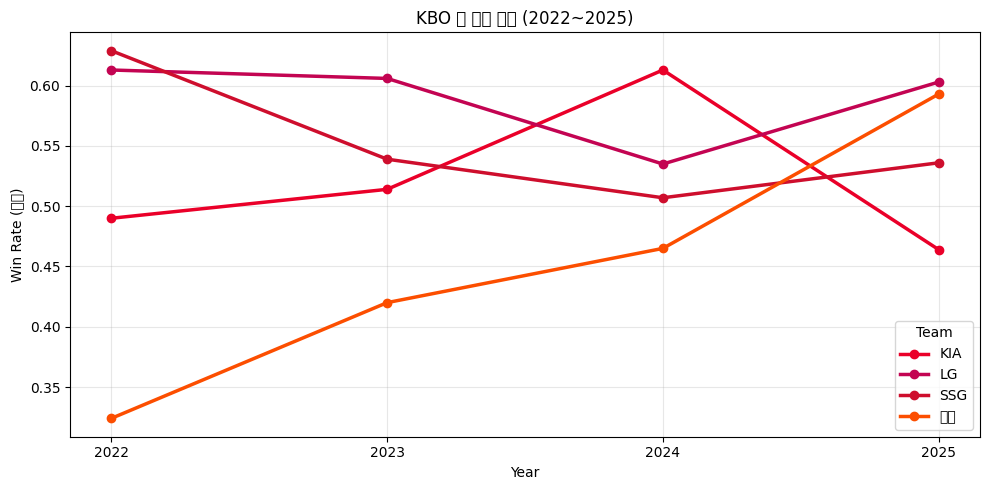

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) 설정
# -----------------------------
PATH = "../data/team_rank_2022_2025_10teams.csv"  # 네가 저장한 경로로 맞추기
YEARS = [2022, 2023, 2024, 2025]
TARGET_TEAMS = ["한화", "LG", "KIA", "SSG"]  # 4팀만 보고 싶으면

TEAM_COLORS = {
    '한화': '#FC4E00',
    'LG': '#C30452',
    'KIA': '#EA0029',
    'SSG': '#CE0E2D',
    '삼성':'#074CA1',
    'NC':'#315288',
    'KT':'#000000',
    '롯데':'#041E42',
    '두산':'#1A1748',
    '키움':'#570514'
}

# -----------------------------
# 1) 데이터 로드 + 타입 정리
# -----------------------------
df = pd.read_csv(PATH, encoding="utf-8-sig")

# 혹시 문자열로 들어왔으면 숫자 변환(이미 변환해서 저장했어도 안전장치)
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["승률"] = pd.to_numeric(df["승률"], errors="coerce")

# 분석/시각화에 필요한 행만
df = df[df["year"].isin(YEARS)].copy()

# -----------------------------
# 2) (옵션) 4팀만 필터
# -----------------------------
df_4 = df[df["팀명"].isin(TARGET_TEAMS)].copy()

# -----------------------------
# 3) 팀별 4년 승률 변화 라인차트
# -----------------------------
plt.figure(figsize=(10, 5))

for team, g in df_4.groupby("팀명"):
    g = g.sort_values("year")
    plt.plot(
        g["year"], g["승률"],
        marker="o",
        linewidth=2.5,
        label=team,
        color=TEAM_COLORS.get(team, None)
    )

plt.title("KBO 팀 승률 변화 (2022~2025)")
plt.xlabel("Year")
plt.ylabel("Win Rate (승률)")
plt.xticks(YEARS)
plt.grid(True, alpha=0.3)
plt.legend(title="Team")
plt.tight_layout()
plt.show()


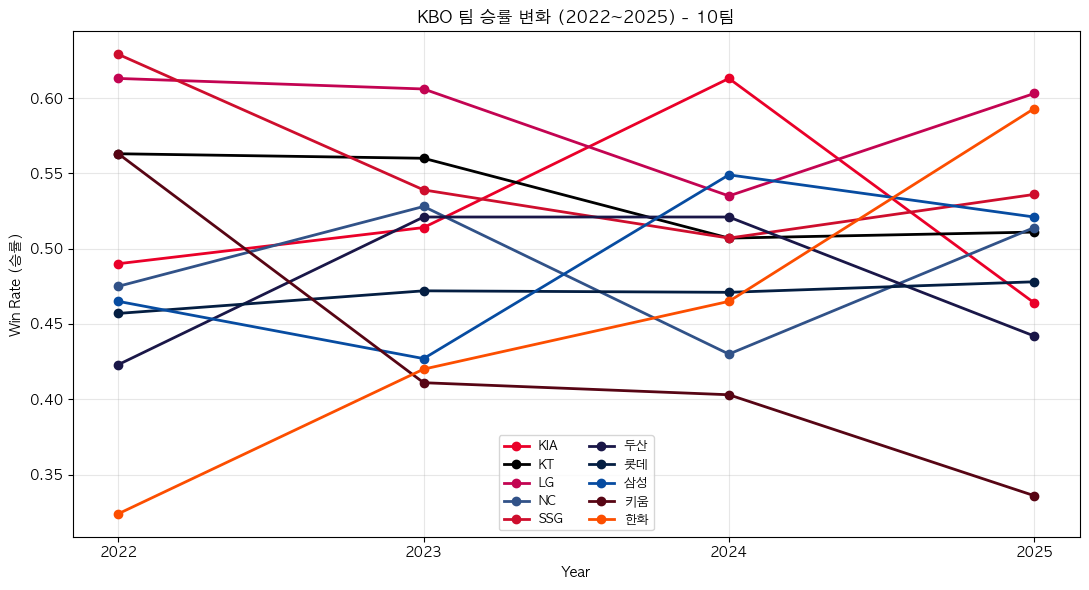

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"   # macOS 한글 폰트
plt.rcParams["axes.unicode_minus"] = False    # 마이너스 깨짐 방지


plt.figure(figsize=(11, 6))
for team, g in df.groupby("팀명"):
    g = g.sort_values("year")
    plt.plot(g["year"], g["승률"],
             marker="o", linewidth=2,
             label=team,
             color=TEAM_COLORS.get(team, None))
plt.title("KBO 팀 승률 변화 (2022~2025) - 10팀")
plt.xlabel("Year"); plt.ylabel("Win Rate (승률)")
plt.xticks(YEARS)
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


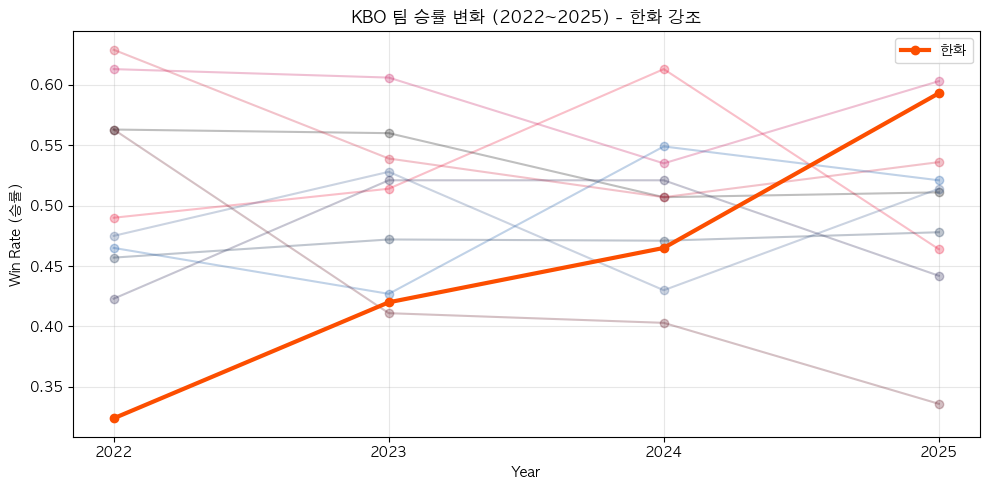

In [10]:
focus = "한화"

plt.figure(figsize=(10, 5))

for team, g in df.groupby("팀명"):
    g = g.sort_values("year")
    is_focus = (team == focus)

    plt.plot(
        g["year"], g["승률"],
        marker="o",
        linewidth=3 if is_focus else 1.5,
        alpha=1.0 if is_focus else 0.25,
        label=team if is_focus else None,
        color=TEAM_COLORS.get(team, None)
    )

plt.title(f"KBO 팀 승률 변화 (2022~2025) - {focus} 강조")
plt.xlabel("Year"); plt.ylabel("Win Rate (승률)")
plt.xticks(YEARS)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


---

In [15]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import time
import os

URL = "https://www.koreabaseball.com/Record/Team/Hitter/Basic1.aspx"

YEARS = [2021, 2022, 2023, 2024, 2025]
TARGET_TEAMS = ["한화", "LG", "KIA", "SSG"]
FILTER_TEAMS = False  # True면 4팀만

OUTPUT_PATH = "../data/team_hitter_basic1_2021_2025.csv"

driver = webdriver.Chrome()
driver.maximize_window()
driver.get(URL)

wait = WebDriverWait(driver, 10)

def find_year_select(driver):
    selects = driver.find_elements(By.CSS_SELECTOR, "select")
    for el in selects:
        try:
            sel = Select(el)
            opts = [o.text.strip() for o in sel.options]
            if any(str(y) in opts for y in YEARS):
                return sel
        except Exception:
            pass
    raise RuntimeError("연도 선택(select) 요소를 찾지 못했어. (페이지 구조 변경 가능)")

def scrape_one_year(year: int):
    # 1) 연도 변경
    year_select = find_year_select(driver)
    year_select.select_by_visible_text(str(year))

    # 2) 테이블 로딩 대기 (핵심)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.tData thead th")))
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.tData tbody tr")))
    time.sleep(0.5)  # 아주 약간만 추가 대기(안정)

    # 3) 헤더에서 컬럼 인덱스 자동 찾기
    headers = [h.text.strip() for h in driver.find_elements(By.CSS_SELECTOR, "table.tData thead th")]

    # 기본값 fallback 포함
    idx_rank = headers.index("순위") if "순위" in headers else 0
    idx_team = headers.index("팀명") if "팀명" in headers else 1
    idx_g    = headers.index("G") if "G" in headers else None
    idx_r    = headers.index("R") if "R" in headers else None
    idx_ab   = headers.index("AB") if "AB" in headers else None
    idx_h    = headers.index("H") if "H" in headers else None
    idx_hr   = headers.index("HR") if "HR" in headers else None
    idx_avg  = headers.index("AVG") if "AVG" in headers else None
    idx_pa   = headers.index("PA") if "PA" in headers else None

    rows = driver.find_elements(By.CSS_SELECTOR, "table.tData tbody tr")

    data = []
    for r in rows:
        tds = r.find_elements(By.TAG_NAME, "td")
        if len(tds) < 5:
            continue

        team = tds[idx_team].text.strip()
        if FILTER_TEAMS and team not in TARGET_TEAMS:
            continue

        row = {
            "year": year,
            "순위": tds[idx_rank].text.strip(),
            "팀명": team,
        }

        # 존재하는 인덱스만 추가
        if idx_avg is not None and idx_avg < len(tds): row["AVG"] = tds[idx_avg].text.strip()
        if idx_g   is not None and idx_g   < len(tds): row["G"]   = tds[idx_g].text.strip()
        if idx_pa  is not None and idx_pa  < len(tds): row["PA"]  = tds[idx_pa].text.strip()
        if idx_ab  is not None and idx_ab  < len(tds): row["AB"]  = tds[idx_ab].text.strip()
        if idx_r   is not None and idx_r   < len(tds): row["R"]   = tds[idx_r].text.strip()   # ✅ 득점
        if idx_h   is not None and idx_h   < len(tds): row["H"]   = tds[idx_h].text.strip()
        if idx_hr  is not None and idx_hr  < len(tds): row["HR"]  = tds[idx_hr].text.strip()

        data.append(row)

    return data

# 4) 연도 루프
all_rows = []
for y in YEARS:
    yearly = scrape_one_year(y)
    print(f"{y} rows:", len(yearly))
    all_rows.extend(yearly)

# 5) 수집 검증
print("TOTAL rows collected:", len(all_rows))
if len(all_rows) == 0:
    driver.quit()
    raise RuntimeError("수집된 행이 0개야. (테이블 selector/로딩/연도변경 구조 재점검 필요)")

df = pd.DataFrame(all_rows)
print("df columns:", list(df.columns))
display(df.head())

# 6) 타입 변환(존재하는 컬럼만)
int_cols = ["year", "순위", "G", "PA", "AB", "R", "H", "HR"]
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "AVG" in df.columns:
    df["AVG"] = pd.to_numeric(df["AVG"], errors="coerce")

df = df.sort_values(["year", "순위"]).reset_index(drop=True)

# 7) 저장
out_dir = os.path.dirname(OUTPUT_PATH)
if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

df.to_csv(OUTPUT_PATH, encoding="utf-8-sig", index=False)
print("✅ 저장 완료:", OUTPUT_PATH)
display(df)

driver.quit()


2021 rows: 10
2022 rows: 10
2023 rows: 10
2024 rows: 10
2025 rows: 10
TOTAL rows collected: 50
df columns: ['year', '순위', '팀명', 'AVG', 'G', 'PA', 'AB', 'R', 'H', 'HR']


,year,순위,팀명,AVG,G,PA,AB,R,H,HR
0,2021,1,롯데,0.278,144,5726,5009,727,1393,107
1,2021,2,두산,0.268,144,5645,4900,738,1314,110
2,2021,3,삼성,0.267,144,5552,4836,712,1292,133
3,2021,4,KT,0.265,144,5627,4810,719,1276,106
4,2021,5,SSG,0.261,144,5736,4899,755,1278,185


✅ 저장 완료: ../data/team_hitter_basic1_2021_2025.csv


,year,순위,팀명,AVG,G,PA,AB,R,H,HR
0,2021,1,롯데,0.278,144,5726,5009,727,1393,107
1,2021,2,두산,0.268,144,5645,4900,738,1314,110
2,2021,3,삼성,0.267,144,5552,4836,712,1292,133
3,2021,4,KT,0.265,144,5627,4810,719,1276,106
4,2021,5,SSG,0.261,144,5736,4899,755,1278,185
5,2021,6,NC,0.261,144,5532,4808,702,1254,170
6,2021,7,키움,0.259,144,5653,4874,722,1262,91
7,2021,8,LG,0.250,144,5533,4750,654,1188,110
8,2021,9,KIA,0.248,144,5577,4831,568,1198,66
9,2021,10,한화,0.237,144,5495,4685,599,1111,80


In [2]:
# ✅ KBO 팀 투수 기본기록(Basic1) 2021~2025 수집 (실점=Runs Allowed 포함)
# - 페이지: https://www.koreabaseball.com/Record/Team/Pitcher/Basic1.aspx
# - 핵심: 투수 테이블의 'R'은 실점(Runs Allowed)이므로 저장 시 'RA'로 rename해서 보관 추천
# - IP 표기('1290 1/3', '123 2/3')는 pandas numeric 변환 시 NaN이 되므로 소수 이닝(float)으로 변환 처리
# - 저장: ../data/team_pitcher_basic1_2021_2025.csv

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import time
import os
import re
import numpy as np

# -----------------------------
# 0) 설정
# -----------------------------
URL = "https://www.koreabaseball.com/Record/Team/Pitcher/Basic1.aspx"
YEARS = [2021, 2022, 2023, 2024, 2025]

# TARGET_TEAMS = ["한화", "LG", "KIA", "SSG"]
FILTER_TEAMS = False  # True면 TARGET_TEAMS만 저장, False면 10팀 전부 저장

OUTPUT_PATH = "../data/team_pitcher_basic1_2021_2025.csv"

# -----------------------------
# 0-1) 유틸: IP 문자열('1290 1/3') → 소수 이닝(float)
# -----------------------------
def ip_to_float(ip):
    """
    KBO 표기 IP 예시:
      - '1290 1/3' -> 1290.333...
      - '123 2/3'  -> 123.666...
      - '45'       -> 45.0
    """
    if ip is None or (isinstance(ip, float) and np.isnan(ip)):
        return np.nan

    s = str(ip).strip()
    if s == "":
        return np.nan

    parts = s.split()

    # 정수 부분
    try:
        base = float(parts[0].replace(",", ""))
    except Exception:
        return np.nan

    # 분수 부분 없음
    if len(parts) == 1:
        return base

    frac = parts[1].strip()

    # 흔한 케이스
    if frac == "1/3":
        return base + 1/3
    if frac == "2/3":
        return base + 2/3

    # 안전망: '1/3' 형태 일반 파싱
    m = re.match(r"^\s*(\d+)\s*/\s*(\d+)\s*$", frac)
    if m:
        num = int(m.group(1))
        den = int(m.group(2))
        if den != 0:
            return base + (num / den)

    return np.nan

# -----------------------------
# 1) 드라이버 실행 & 페이지 접속
# -----------------------------
driver = webdriver.Chrome()
driver.maximize_window()
driver.get(URL)

wait = WebDriverWait(driver, 10)

# -----------------------------
# 2) 유틸: 연도 선택 select 찾기
# -----------------------------
def find_year_select(driver):
    selects = driver.find_elements(By.CSS_SELECTOR, "select")
    for el in selects:
        try:
            sel = Select(el)
            opts = [o.text.strip() for o in sel.options]
            if any(str(y) in opts for y in YEARS):
                return sel
        except Exception:
            pass
    raise RuntimeError("연도 선택(select) 요소를 찾지 못했어. (페이지 구조 변경 가능)")

# -----------------------------
# 3) 특정 연도 1개 수집
# -----------------------------
def scrape_one_year(year: int):
    # 연도 변경
    year_select = find_year_select(driver)
    year_select.select_by_visible_text(str(year))

    # 테이블 로딩 대기
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.tData thead th")))
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.tData tbody tr")))
    time.sleep(0.5)

    headers = [h.text.strip() for h in driver.find_elements(By.CSS_SELECTOR, "table.tData thead th")]

    # 필수 헤더 존재 여부 점검 (에러를 빨리 내서 원인 파악)
    required = ["순위","팀명","ERA","G","W","L","SV","HLD","WPCT","IP","H","HR","BB","HBP","SO","R","ER"]
    missing = [c for c in required if c not in headers]
    if missing:
        raise RuntimeError(f"{year}년: 예상 헤더가 없어. missing={missing}. headers={headers}")

    idx_rank = headers.index("순위")
    idx_team = headers.index("팀명")
    idx_era  = headers.index("ERA")
    idx_g    = headers.index("G")
    idx_w    = headers.index("W")
    idx_l    = headers.index("L")
    idx_sv   = headers.index("SV")
    idx_hld  = headers.index("HLD")
    idx_wpct = headers.index("WPCT")
    idx_ip   = headers.index("IP")
    idx_h    = headers.index("H")
    idx_hr   = headers.index("HR")
    idx_bb   = headers.index("BB")
    idx_hbp  = headers.index("HBP")
    idx_so   = headers.index("SO")
    idx_r    = headers.index("R")     # ✅ 투수 테이블의 R = 실점(Runs Allowed)
    idx_er   = headers.index("ER")

    # WHIP 표기는 페이지에 따라 'WHIP' 또는 'WHI'로 뜰 수 있어 예외 처리
    idx_whip = None
    if "WHIP" in headers:
        idx_whip = headers.index("WHIP")
    elif "WHI" in headers:
        idx_whip = headers.index("WHI")

    rows = driver.find_elements(By.CSS_SELECTOR, "table.tData tbody tr")

    data = []
    for r in rows:
        tds = r.find_elements(By.TAG_NAME, "td")
        if len(tds) < len(headers):
            continue

        team = tds[idx_team].text.strip()
        if FILTER_TEAMS:
            # FILTER_TEAMS=True로 쓸 거면 TARGET_TEAMS를 위에서 활성화해줘
            if team not in TARGET_TEAMS:
                continue

        row = {
            "year": year,
            "순위": tds[idx_rank].text.strip(),
            "팀명": team,
            "ERA": tds[idx_era].text.strip(),
            "G": tds[idx_g].text.strip(),
            "W": tds[idx_w].text.strip(),
            "L": tds[idx_l].text.strip(),
            "SV": tds[idx_sv].text.strip(),
            "HLD": tds[idx_hld].text.strip(),
            "WPCT": tds[idx_wpct].text.strip(),
            "IP": tds[idx_ip].text.strip(),     # 문자열 그대로 수집 → 이후 변환
            "H": tds[idx_h].text.strip(),
            "HR": tds[idx_hr].text.strip(),
            "BB": tds[idx_bb].text.strip(),
            "HBP": tds[idx_hbp].text.strip(),
            "SO": tds[idx_so].text.strip(),
            "RA": tds[idx_r].text.strip(),      # ✅ 실점은 RA로 저장
            "ER": tds[idx_er].text.strip(),
        }

        if idx_whip is not None:
            row["WHIP"] = tds[idx_whip].text.strip()

        data.append(row)

    return data

# -----------------------------
# 4) 연도 루프 수집
# -----------------------------
all_rows = []
for y in YEARS:
    yearly = scrape_one_year(y)
    print(f"{y} rows:", len(yearly))
    all_rows.extend(yearly)

print("TOTAL rows collected:", len(all_rows))
if len(all_rows) == 0:
    driver.quit()
    raise RuntimeError("수집된 행이 0개야. (테이블 selector/로딩/연도변경 구조 재점검 필요)")

df = pd.DataFrame(all_rows)
print("df columns:", list(df.columns))
print(df.head())

# -----------------------------
# 5) 타입 변환
# -----------------------------
# IP 먼저 변환 (문자열 '1290 1/3' → float)
df["IP"] = df["IP"].apply(ip_to_float)

# 숫자형 컬럼 변환
int_cols = ["year","순위","G","W","L","SV","HLD","H","HR","BB","HBP","SO","RA","ER"]
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")

float_cols = ["ERA","WPCT","WHIP"]
for c in float_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")

df = df.sort_values(["year", "순위"]).reset_index(drop=True)

# IP 변환이 잘 됐는지 빠른 점검 (원하면 주석 해제)
# print("IP NaN ratio:", df["IP"].isna().mean())
# print(df[df["year"]==2025].sort_values("IP", ascending=False)[["팀명","IP"]].head())

# -----------------------------
# 6) CSV 저장 (../data)
# -----------------------------
out_dir = os.path.dirname(OUTPUT_PATH)
if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

df.to_csv(OUTPUT_PATH, encoding="utf-8-sig", index=False)
print("✅ 저장 완료:", OUTPUT_PATH)
print(df.head())

driver.quit()


2021 rows: 10
2022 rows: 10
2023 rows: 10
2024 rows: 10
2025 rows: 10
TOTAL rows collected: 50
df columns: ['year', '순위', '팀명', 'ERA', 'G', 'W', 'L', 'SV', 'HLD', 'WPCT', 'IP', 'H', 'HR', 'BB', 'HBP', 'SO', 'RA', 'ER', 'WHIP']
   year 순위  팀명   ERA    G   W   L  SV HLD   WPCT        IP     H   HR   BB  \
0  2021  1  LG  3.57  144  72  58  32  81  0.554  1272 1/3  1126   80  545   
1  2021  2  KT  3.67  144  76  59  33  74  0.563      1264  1176   86  489   
2  2021  3  두산  4.26  144  71  65  28  61  0.522  1269 1/3  1295  104  587   
3  2021  4  삼성  4.30  144  76  59  46  80  0.563      1259  1297  131  530   
4  2021  5  키움  4.31  144  70  67  30  56  0.511  1263 1/3  1281  101  566   

  HBP    SO   RA   ER  WHIP  
0  98  1068  561  505  1.31  
1  42  1062  584  515  1.32  
2  73  1045  656  601  1.48  
3  51  1038  658  601  1.45  
4  80   900  700  605  1.46  
✅ 저장 완료: ../data/team_pitcher_basic1_2021_2025.csv
   year  순위  팀명   ERA    G   W   L  SV  HLD   WPCT           IP     H   H